## ESTIMATING APPROPRIATE TOLERANCE

In [6]:
import random
import scipy.stats as st
import numpy as np
import math
from math import gamma, pi
import time
import scipy
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy.random as rnd
import pickle
import os.path
from deap import creator, base, tools, algorithms
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import scipy.linalg as la

In [7]:
def getAllSpansEqual(numOfDims, spanForAll):
    return np.ones(numOfDims)*spanForAll

def getRandomUniformSpans(numOfDims, low, high):
    return np.random.rand(numOfDims)*(high-low) + low

def getVolumeElipsoid(params):
    nDims = params.size
    return pow(pi, (nDims/2)) / gamma(nDims/2 + 1) * np.prod(params)

def getVolumeElipsoid2(params):
    nDims = params.size
    return (2/nDims)*pow(pi, (nDims/2)) / gamma(nDims/2) * np.prod(params)

# print(getVolumeElipsoid(np.array( [1,5,4])))
# print(getVolumeElipsoid2(np.array( [1,5,4])))

def fitEllipsoid_dumb(points, elipsoidParameters):
    d = np.size(elipsoidParameters)
    elipsoidParameters.shape=(1,d)
    
    max_dist = np.max( np.sum(np.square(np.divide(points,elipsoidParameters)),1) )
    increase_factor = math.sqrt(max_dist) + 0.00001
    print("increase_factor", increase_factor)
    new_ellipsoid_parameters = increase_factor*elipsoidParameters
    return new_ellipsoid_parameters

def isInElipsoid(points, elipsoidParameters):
    # points is a d x num_p numpy matrix where d is the number of dimensions and num_p is the number of points.
    # elipsoidParameters is an d-dimensional array, where each element is the RADIUS of the axis.
    d = np.size(elipsoidParameters)
    elipsoidParameters.shape=(1,d) 
    return np.sum(np.square(np.divide(points,elipsoidParameters)),1) <= 1

In [8]:
model_index = 3    
model_str = '0'+str(model_index+1)+'_'

region_files = ["results_opt", "results_opt_rep1", "results_opt_rep2"]

regions = []

for region_file in region_files:
    base_path_train = os.path.join("..", region_file )
    for i in range(0, 10):
        regions.append(os.path.join( base_path_train, model_str+"bioproc_Region0ViableSet_Iter" + str(i+1) + ".p"))

print(regions)

viableTrainPoints = []  
for region_file in regions: 
    viablePointsRegion = pickle.load(open(region_file, "rb")) 
    viableTrainPoints.extend(viablePointsRegion)
viableTrainPoints = np.array(viableTrainPoints)

print( viableTrainPoints.shape )

P = viableTrainPoints.T
# visualizeEllipse( ep, rand_points )

['..\\results_opt\\04_bioproc_Region0ViableSet_Iter1.p', '..\\results_opt\\04_bioproc_Region0ViableSet_Iter2.p', '..\\results_opt\\04_bioproc_Region0ViableSet_Iter3.p', '..\\results_opt\\04_bioproc_Region0ViableSet_Iter4.p', '..\\results_opt\\04_bioproc_Region0ViableSet_Iter5.p', '..\\results_opt\\04_bioproc_Region0ViableSet_Iter6.p', '..\\results_opt\\04_bioproc_Region0ViableSet_Iter7.p', '..\\results_opt\\04_bioproc_Region0ViableSet_Iter8.p', '..\\results_opt\\04_bioproc_Region0ViableSet_Iter9.p', '..\\results_opt\\04_bioproc_Region0ViableSet_Iter10.p', '..\\results_opt_rep1\\04_bioproc_Region0ViableSet_Iter1.p', '..\\results_opt_rep1\\04_bioproc_Region0ViableSet_Iter2.p', '..\\results_opt_rep1\\04_bioproc_Region0ViableSet_Iter3.p', '..\\results_opt_rep1\\04_bioproc_Region0ViableSet_Iter4.p', '..\\results_opt_rep1\\04_bioproc_Region0ViableSet_Iter5.p', '..\\results_opt_rep1\\04_bioproc_Region0ViableSet_Iter6.p', '..\\results_opt_rep1\\04_bioproc_Region0ViableSet_Iter7.p', '..\\result

In [9]:
# P = d x numP ( points )
# tolerance = skalar ( priporočeno = ___ )

maxSteps = 1000

err = 10000
d, N = np.shape(P)
Q = np.ones((d+1, N))
Q[0:d,:] = P

# initializations
# -----------------------------------
count = 1
errors = 1
u = (1/N) * np.ones((N,1))          # 1st iteration

vols = []
errors = []

# Khachiyan Algorithm
# -----------------------------------
while (maxSteps > count):
    X = np.dot( np.dot( Q   , np.diagflat(u))    , Q.T ) # % X = \sum_i ( u_i * q_i * q_i')  is a (d+1)x(d+1) matrix
    M = (np.dot( Q.T , np.linalg.inv(X) ) * Q.T).sum(-1)
    # print("M", M)
    M.shape=(N,1)
    j = np.argmax(M)
    maximum = M[j,0]
    step_size = (maximum - d -1)/((d+1)*(maximum-1))
    new_u = (1 - step_size)*u
    new_u[j] = new_u[j] + step_size
    count += 1
    err = np.linalg.norm(new_u - u)
    u = new_u
    print("err", err)
    
    ########### DODATEK:
    U = np.diagflat(u)
    Pu = np.dot(P,u)
    C = (1/d) * np.linalg.pinv( np.dot( np.dot( P , U) , P.T ) - np.dot(Pu, Pu.T ))
    b = np.dot(P , u)
    C_minus = C/(1-np.dot( b.T, np.dot(C,b) )  )
    (eigvals,eigvecs) = la.eig(C_minus)
    P2 = np.dot( eigvecs.T, (P - b))

    R = 1./np.sqrt(np.abs(eigvals))
    R.shape = (np.size(R), 1)

    R2 = R*np.sqrt( np.max(np.sum(np.square(np.divide( P2, R )),0)) )
    vol_good = getVolumeElipsoid(R2)
    vols.append(vol_good)
    errors.append(err)
    

U = np.diagflat(u)

# the A matrix for the ellipse
# --------------------------------------------
Pu = np.dot(P,u)
C = (1/d) * np.linalg.pinv( np.dot( np.dot( P , U) , P.T ) - np.dot(Pu, Pu.T ))
b = np.dot(P , u)

C_minus = C/(1-np.dot( b.T, np.dot(C,b) )  )
(eigvals,eigvecs) = la.eig(C_minus)
P2 = np.dot( eigvecs.T, (P - b))

R = 1./np.sqrt(np.abs(eigvals))
R.shape = (np.size(R), 1)

R2 = R*np.sqrt( np.max(np.sum(np.square(np.divide( P2, R )),0)) )
print("increase factor:", np.sqrt( np.max(np.sum(np.square(np.divide( P2, R )),0)) ))
print("Check:", np.max(np.sum(np.square(np.divide( P2, R2 )),0)))

print("count:", count)

err 0.06991589036114028
err 0.05863015128641332
err 0.05391181366761751
err 0.0535110390698116
err 0.050520681108765175
err 0.05041931927113707
err 0.05048276866018705
err 0.04939702334004269
err 0.0478454623306602
err 0.0480792249476208
err 0.049366186644691244
err 0.04828358596685411
err 0.044384715159911055
err 0.043121586448546564
err 0.04307745150543848
err 0.038787734370877056
err 0.036273042712478706
err 0.034961799673845675
err 0.034456715932678676
err 0.03476755354029592
err 0.0350229569649642
err 0.03371816548436974
err 0.03483019913673954
err 0.03252939048635497
err 0.03168480965970266
err 0.03205734403609895
err 0.02880042873810535
err 0.0269231039256817
err 0.026670805192842355
err 0.0243270852343354
err 0.023800007116548484
err 0.0252099498593331
err 0.0248901483018843
err 0.024488768656046773
err 0.02091313993204488
err 0.02165013129853361
err 0.022923927485477134
err 0.02109090388905796
err 0.021697910401673633
err 0.02034510904696807
err 0.019757615949172747
err 0.0184

err 0.0026731765983261093
err 0.0027535464975068477
err 0.0026824598909575004
err 0.0029027970056206827
err 0.002773750569321725
err 0.0026901293693148516
err 0.002581103467106448
err 0.00256196774488534
err 0.00261892737960633
err 0.0025336636650165776
err 0.0025645046642792423
err 0.0025653645772657817
err 0.0026958080852140737
err 0.002788183460744934
err 0.0028341046936154386
err 0.0027218192518267932
err 0.0024608354768008915
err 0.002444332378030185
err 0.0024034755323228255
err 0.0026292742419724946
err 0.002622531238613939
err 0.002736282385540698
err 0.002730251212079381
err 0.0026451146652249694
err 0.002675625209154893
err 0.0027347053915225215
err 0.0028573882280974183
err 0.0026732777011637975
err 0.002697122959281193
err 0.002537116322318883
err 0.002605051206986917
err 0.0028015281489279955
err 0.0028373940108647284
err 0.0023982317952203976
err 0.0026128468529522165
err 0.0025415609543855758
err 0.0025054353109722873
err 0.002394702456753278
err 0.0024365283193608107
er

err 0.0013740512635456862
err 0.0014091603860053143
err 0.0014229058408520004
err 0.0014478388922633703
err 0.0014220782269533674
err 0.0014684815540346927
err 0.0015126418741664275
err 0.0015568437704269252
err 0.0016262053099585746
err 0.0016453636159761797
err 0.0015006712869820187
err 0.00155068501447997
err 0.0016904315832300487
err 0.0016888325639402308
err 0.001542657134547119
err 0.0015604834866703146
err 0.0015914762516352839
err 0.0014184784735302588
err 0.0013092571606170174
err 0.0013756052962956974
err 0.0013298537651762932
err 0.0013182793295972803
err 0.0013018099591898512
err 0.0012766214594167168
err 0.0013650237104344837
err 0.0014368133387124666
err 0.0013279228707430957
err 0.0013276033140412846
err 0.0013581442740629567
err 0.0014460645880330692
err 0.0012690074514039827
err 0.0013689664159423868
err 0.0013109317479662686
err 0.0013909461847575345
err 0.0014069402046624254
err 0.0014884131920088997
err 0.0014612738147145319
err 0.001301944092416682
err 0.0013986115

err 0.0009669680785943989
err 0.0009985379310436828
err 0.0010419202318274112
err 0.0010511427508016296
err 0.0010051577633936497
err 0.0010155088342167756
err 0.00102876808625866
err 0.0010927486609716161
err 0.0010397313700293473
err 0.0010587926560644667
err 0.0009970352757936373
err 0.0008845743587262734
err 0.0008777928831784332
err 0.0009595621702483142
err 0.0009177288302477414
err 0.0009177530213108617
err 0.0009182142483764756
err 0.000934248167531149
err 0.0009337312863499719
err 0.0009578816460659021
err 0.0009738461496718157
err 0.0010309094753265156
err 0.0009414736603726774
err 0.0009603926147954938
err 0.0009616119527581454
err 0.0009498374886909405
err 0.0010221012907878349
err 0.001006944484126233
err 0.0010247248977263727
err 0.0008539885624550284
err 0.0008677252082339666
err 0.0008728717051875395
err 0.0009285105214344983
increase factor: 0.5012982743333781
Check: 0.9999999999999998
count: 1000


In [40]:
# %matplotlib qt
%matplotlib inline

In [14]:
# check if the transformation was allowed -> we multiplied with orthogonal matrix.
vec_err = (np.dot(eigvecs.T,  eigvecs) - np.eye(12))
vec_err.shape=(12*12,1)
print("error of testing if U eigenvectors are orthogonal:", np.linalg.norm(vec_err))

error of testing if U eigenvectors are orthogonal: 1.3095522301144595e-11


Check: 0.9999999999999998


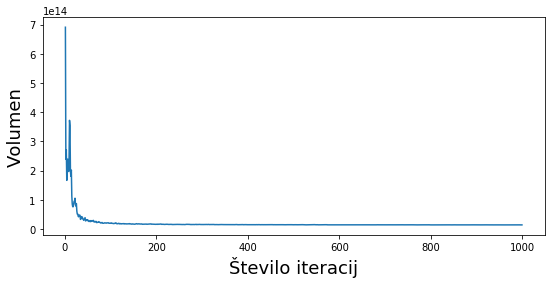

In [41]:
print("Check:", np.max(np.sum(np.square(np.divide( P2, R2 )),0)))
x_os = np.arange(len(vols)) + 1
y_os = vols
z_os = errors

plt.figure(1, figsize=(9,4))
plt.plot(x_os, y_os)
plt.xlabel("Število iteracij", fontsize=18)
plt.ylabel("Volumen", fontsize=18)
plt.savefig('Tolerance1.eps', bbox_inches='tight', format='eps')
plt.show()

Check: 0.9999999999999998


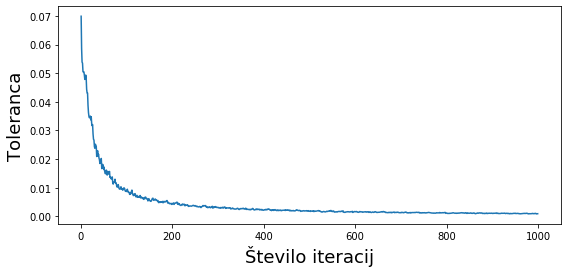

In [42]:
print("Check:", np.max(np.sum(np.square(np.divide( P2, R2 )),0)))
x_os = np.arange(len(vols)) + 1
y_os = vols
z_os = errors

plt.figure(2, figsize=(9,4))
plt.plot(x_os, z_os)
plt.xlabel("Število iteracij", fontsize=18)
plt.ylabel("Toleranca", fontsize=18)
plt.savefig('Tolerance2.eps', bbox_inches='tight', format='eps')
plt.show()

In [12]:
print(vols[990])
print(vols[100])
print(errors[100])
print(errors[850])

13634319360363.518
20478691602266.723
0.009140973320137568
0.0011086328061186586
